In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

import numpy as np

import seaborn as sns

import plotly.express as px

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, make_scorer

import copy

SEED = 24

# Выбор локации для скважины

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных

Данные геологоразведки трёх регионов находятся в файлах: `geo_data_0.csv, geo_data_1.csv и geo_data_2.csv.`

- `id` — уникальный идентификатор месторождения;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в месторождении (тыс. баррелей).

## Загрузка и подготовка данных

Загрузим данные и посмотрим на их структуру.

In [3]:
dfs = []
files = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']

for file in files:
    dfs.append(pd.read_csv(file, index_col='id'))

In [4]:
for df in dfs:
    display(df.head())
    print(df.info())
    print('Повторяющихся строк:', df.duplicated().sum())

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None
Повторяющихся строк: 0


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None
Повторяющихся строк: 0


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None
Повторяющихся строк: 0


Как мы видим, данные чистые - нет пропусков и грубых повторов. Разделим наши выборки на обучающие и тестовые. Валидационные отдельно выделять не будем, так как будем использовать метод кросс-валидации. Напишем функцию для разделения выборок.

In [5]:
def split_df_regression(df, target_column_name:str, valid_test_flag:bool, seed = 42):
    
    '''
    This function takes dataframe, target column name and a flag, which means should it return train-valid-test df's 
    (features_train, features_valid, features_test and target_train, target_valid, target_test) or only train-test.
    In case if flag = False, than the function will split the df in proportion 75/25, if True - 60/20/20.
    '''
    
    from sklearn.model_selection import train_test_split
    
    if valid_test_flag:
        df_train, df_valid = train_test_split(df, test_size=0.2, random_state=seed)
        df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=seed)
        
        features_train = df_train.drop([target_column_name], axis=1)
        target_train = df_train[target_column_name]
        
        features_valid = df_valid.drop([target_column_name], axis=1)
        target_valid = df_valid[target_column_name]
        
        features_test = df_test.drop([target_column_name], axis=1)
        target_test = df_test[target_column_name]
        
        return features_train, features_valid, features_test, target_train, target_valid, target_test
    
    df_train, df_test = train_test_split(df, test_size=0.25, random_state=seed)
    
    features_train = df_train.drop([target_column_name], axis=1)
    target_train = df_train[target_column_name]
    
    features_test = df_test.drop([target_column_name], axis=1)
    target_test = df_test[target_column_name]
    
    return features_train, features_test, target_train, target_test

Применим нашу функцию и соберем разделенные выборки в контейнеры.

In [6]:
features_train_container = []
features_test_container = []
target_train_container = []
target_test_container = []

for df in dfs:
    features_train, features_test, target_train, target_test = split_df_regression(df, 'product', False, SEED)
    
    features_train_container.append(features_train)
    features_test_container.append(features_test)
    target_train_container.append(target_train)
    target_test_container.append(target_test)

## Обучение и проверка модели

На графиках для второго региона видна практически прямая зависимость запасов от признака `f2`. 

Напишем функцию для подсчета RMSE, обучим модель и запишем полученные результаты по каждому региону в отдельный словарь.

In [7]:
def rmse(target_true, target_predicted):
    return (mean_squared_error(target_true, target_predicted))**(1/2)

In [8]:
model = LinearRegression()

results = {'mean': [],
           'RMSE': []
           }

targets_pred = []


for X_train, X_test, y_train, y_test in zip(features_train_container,
                                            features_test_container, 
                                            target_train_container, 
                                            target_test_container):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    targets_pred.append(pd.Series(y_pred, index=y_test.index))
    results['RMSE'].append(rmse(y_test, y_pred))    
    results['mean'].append(y_pred.mean())
    
        
pd.DataFrame(results, index=[1,2,3])

,mean,RMSE
1,92.446468,37.814795
2,68.410516,0.891638
3,94.844062,40.226046


Интересный результат. В первом и третьем регионе среднее значение запасов сырья в месторождении выше, чем во втором. Но при этом линейная регрессия гораздо лучше расчитала значения именно для второго региона, RMSE всего 0.89 против ~40 в двух других регионах. Посмотрим на респределения поближе. 

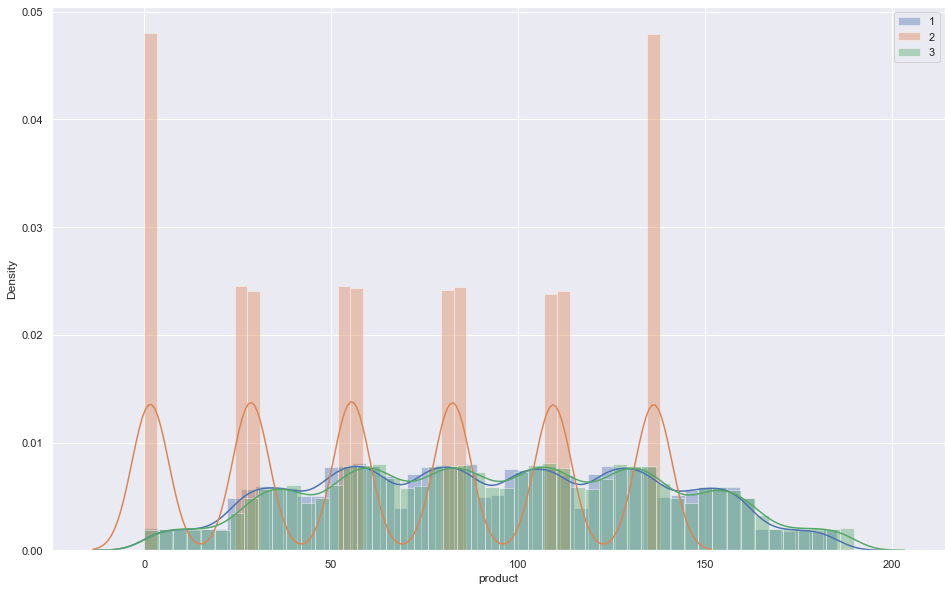

In [9]:
sns.set(rc={'figure.figsize':(16,10)})
for i, df in enumerate(dfs):
    sns.distplot(df['product'], label=i + 1)
    plt.legend()

Пики на графике для второго региона указывают, что там есть места, где сконцентрированы основные месторождения, в то время как для двух других регионов запасы распределены более равномерно. Интересно так же взглянуть на зависимости признаков для второго региона.

Дополнительно посмотрим на корреляции признаков для каждого региона.

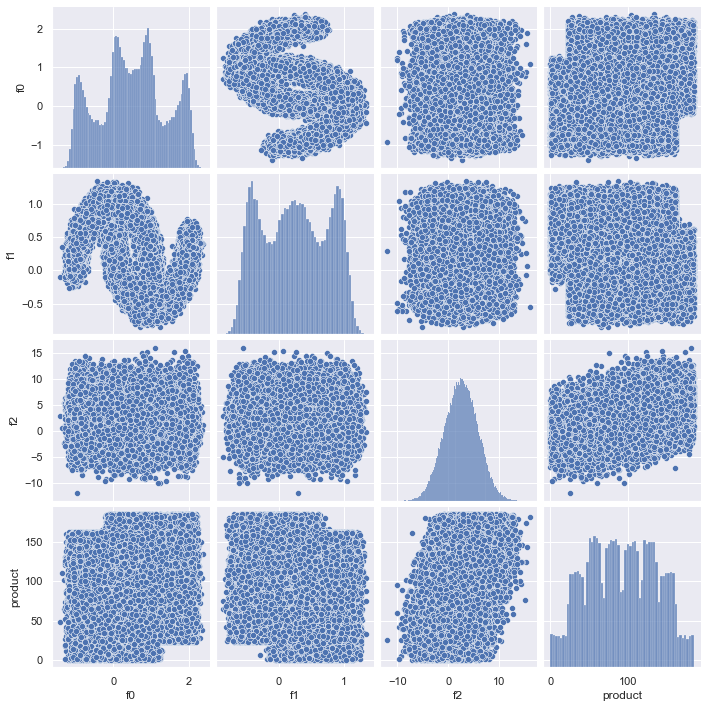

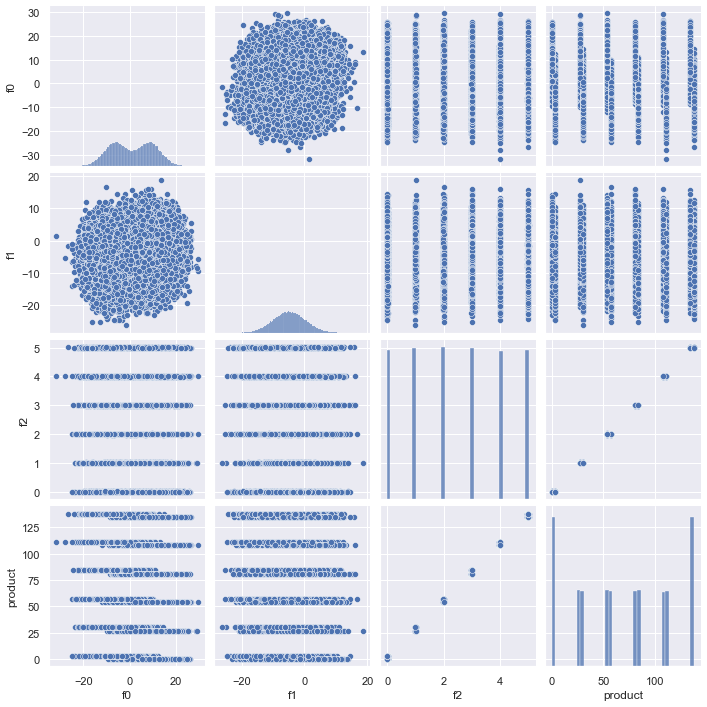

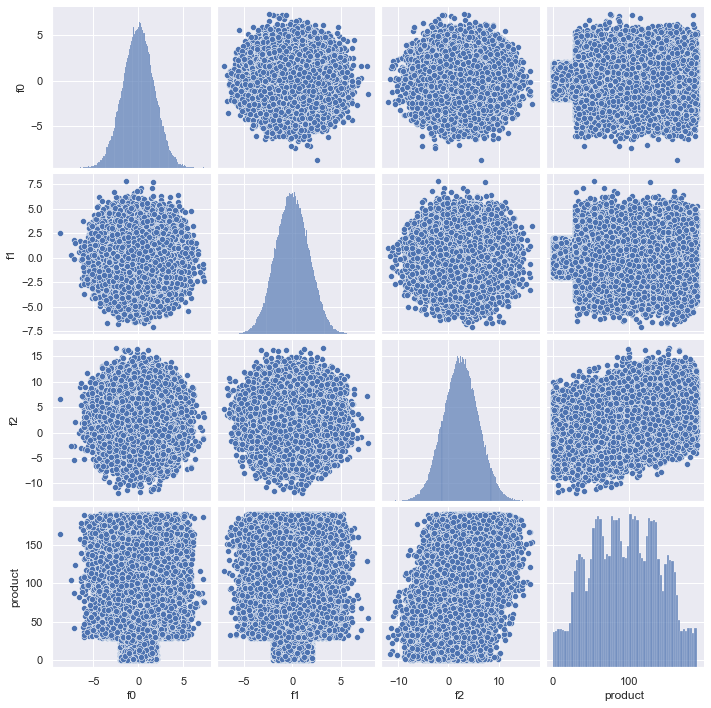

In [10]:
for df in dfs:
    sns.pairplot(df)   

Во втором регионе признак `f2` практически напрямую коррелирует с таргетом, что объяснет почему линейная регрессия дала такие хорошие результаты для этого региона.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [11]:
ONE_BARREL_PROFIT = 450
BUDGET = 10000000000

In [12]:
one_well_cost = BUDGET / 200
one_well_cost

50000000.0

Пятьдесят миллионов это стоимость одной скважины. Теперь посмотрим сколько нам надо добыть из нее сырья, чтобы выйти в плюс.

In [13]:
minimum_barrels = one_well_cost / (ONE_BARREL_PROFIT * 1000)
minimum_barrels

111.11111111111111

Больше ста десяти тысяч бареллей со скважины. Это несколько больше, чем средние значения в регионах номер один и три. И сильно выше, того, что у нас есть во втором.

## Расчёт прибыли и рисков 

Напишем функцию для подсчета прибыли.

In [14]:
def profit(target, probabilities, one_well_cost, count):
    top = probabilities.sort_values(ascending=False).head(count)
    total_profit = (target.loc[top.index][:count] * 1000 * ONE_BARREL_PROFIT).sum() #Добавил срез по размеру count. 
    return total_profit - (one_well_cost * count)

По условиям задачи:

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Процедурой Bootstrap оценим доверительные интервалы для моделей машинного обучения.

In [15]:
WELLS = 500
BEST_WELLS = 200
SAMPLES_FOR_BOOTSTRAP = 1000
PROBABILITY_OF_LOST = 0.025
CONFIDENCE_INTERVAL = 0.95

Wall time: 7.83 s


,mean,95_conf_interval,std,%_of_loss
1,470.280069,"(-32.9616782557944, 950.8199955265629)",261.682270,3.6
2,497.556590,"(88.90001664888108, 928.6257540948429)",217.944207,0.3
3,384.363746,"(-194.04206253742205, 923.7938973495726)",279.637218,9.5


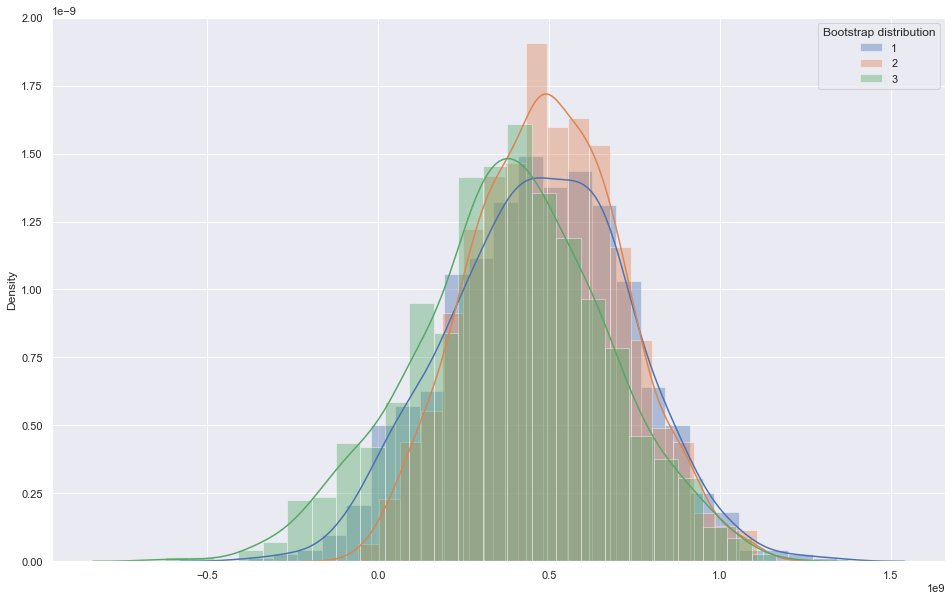

In [16]:
%%time

results = {
    'mean':[],
    '95_conf_interval':[],
    'std':[],
    '%_of_loss':[]
}

random_state = np.random.RandomState(seed=SEED)

for lbl, (target_valid, target_pred) in enumerate(zip(target_test_container, targets_pred)):
    values = []
    
    for i in range(SAMPLES_FOR_BOOTSTRAP):
        target_subsample = target_valid.sample(WELLS, replace=True, random_state=random_state)
        probs_subsample = target_pred.loc[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample, one_well_cost, BEST_WELLS))
    
    values = pd.Series(values)
    lower = (1 - CONFIDENCE_INTERVAL) / 2
    upper = (1 + CONFIDENCE_INTERVAL) / 2
    results['mean'].append(values.mean()/10e5)
    results['95_conf_interval'].append((values.quantile(lower)/10e5, values.quantile(upper)/10e5))
    results['std'].append(values.std()/10e5)
    results['%_of_loss'].append(((values < 0).mean()*100))
    fig = sns.distplot(values, label=lbl + 1)
    fig.set_ylim([0, 0.2e-8])
    plt.legend(title="Bootstrap distribution")

pd.DataFrame(results, index=[1,2,3])

## Вывод

По результатам применения методики Bootsrap мы можем сказать, что наиболее перспективным для разработки является регион №2. Только для него мы получили вероятность потерь ниже двух с половиной процентов.